Instrucciones para examen
Objetivo: Este examen tiene como objetivo evaluar la capacidad del estudiante para limpiar, explorar, implementar y evaluar modelos de clasificación en un dataset de diabetes. Utilizaremos el «Diabetes Dataset» disponible en Kaggle. Los estudiantes deben demostrar habilidades prácticas en la manipulación de datos, creación de visualizaciones y modelado predictivo.

Contexto y Descripción del Dataset

El «Diabetes Dataset» contiene datos de salud de mujeres de ascendencia indígena Pima que viven cerca de Phoenix, Arizona, EE.UU. La tarea es predecir si un paciente tiene diabetes o no, basándose en ciertas medidas diagnósticas incluidas en el dataset.

Diccionario de Datos:

* Pregnancies: Número de embarazos.
* Glucose: Concentración de glucosa en plasma a las 2 horas en una prueba oral de tolerancia a la glucosa.
* BloodPressure: Presión arterial diastólica (mm Hg).
* SkinThickness: Espesor del pliegue cutáneo del tríceps (mm).
* Insulin: Niveles séricos de insulina a las 2 horas (mu U/ml).
* BMI: Índice de masa corporal (peso en kg / (altura en m)^2).
* DiabetesPedigreeFunction: Función de pedigrí de diabetes.
* Age: Edad (años).
* Outcome: Variable objetivo (1: diabetes, 0: no diabetes).

In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss
from collections import Counter
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

In [2]:
# Carga de los dos datasets
data = pd.read_csv('../data/diabetes.csv')
print(data.shape)
data.head(10)

(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


# 1) Limpieza de Datos:

## Identificación y eliminación de valores duplicados


In [3]:
print("Duplicados: ", data.duplicated().sum())

Duplicados:  0


## Verificación y ajuste de tipos de datos:

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
data['Outcome'].unique()

array([1, 0], dtype=int64)

In [7]:
# Cambiamos a tipo boleano
data['Outcome'] = data['Outcome'].astype(bool)
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    bool   
dtypes: bool(1), float64(2), int64(6)
memory usage: 48.9 KB


## Corrección de inconsistencias en valores categóricos: 
* No hay variables categoricos

## Manejo de valores faltantes adecuadamente:
* No hay datos faltantes

In [8]:
data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [17]:
zero_counts = (data == 0).sum()
print("Cantidad de valores en 0 por columna:")
print(zero_counts)

Cantidad de valores en 0 por columna:
Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64


# 2) Exploración de Datos:

## Estadísticas descriptivas:

In [9]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


## Visualizaciones univariadas y multivariadas:

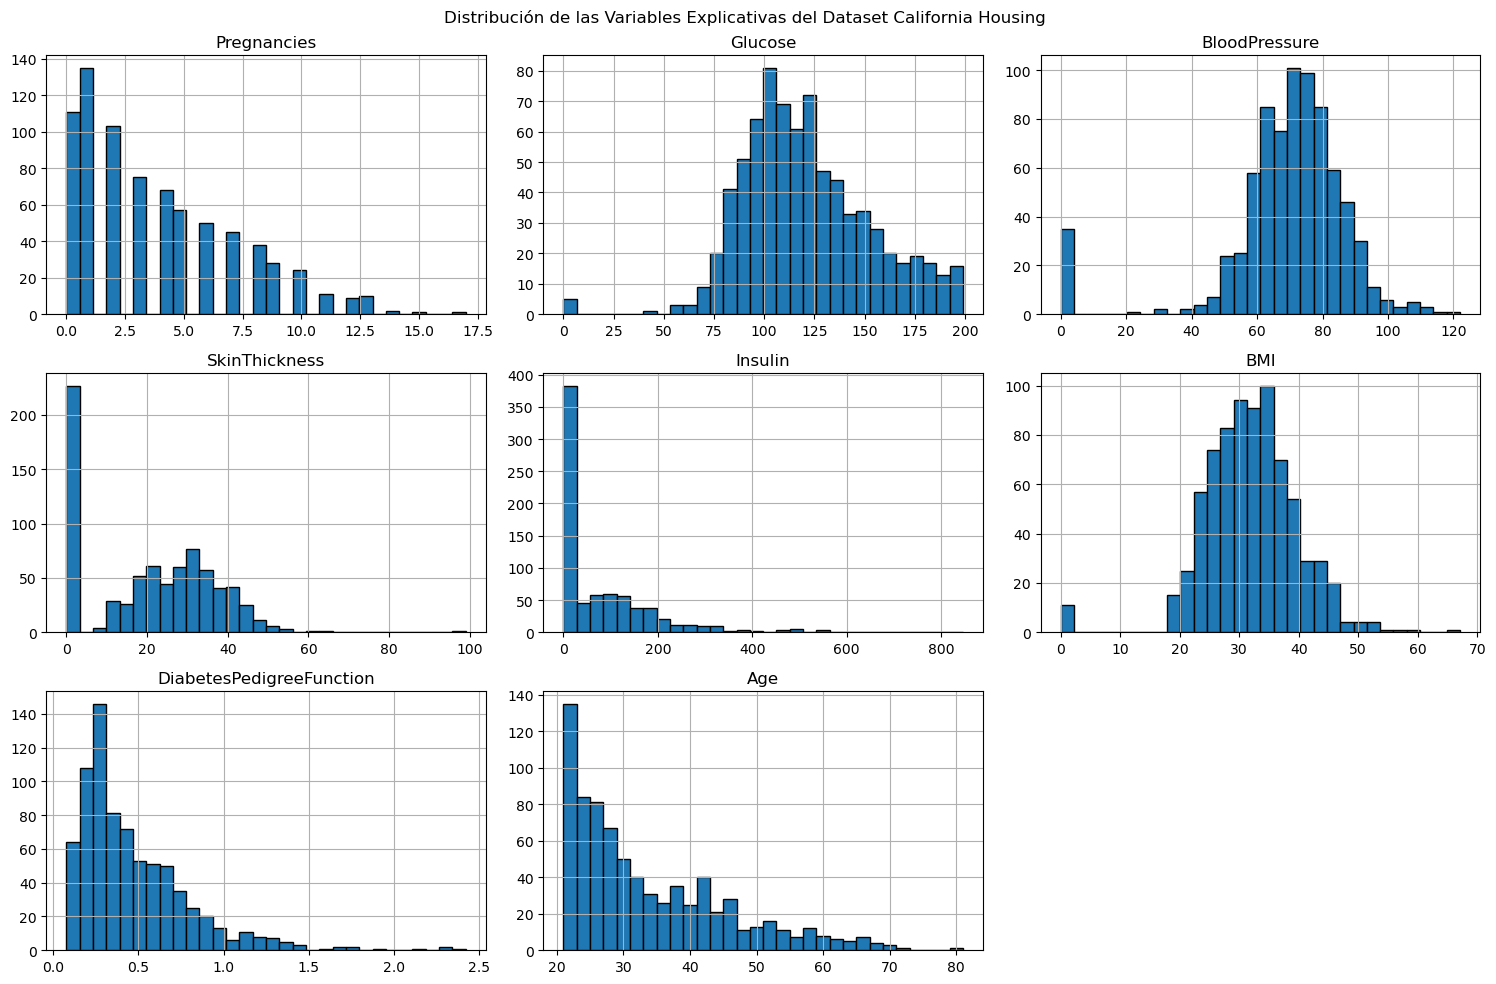

In [10]:
# Crear histogramas para cada característica
data.hist(bins=30, figsize=(15, 10), edgecolor='black')
plt.suptitle('Distribución de las Variables Explicativas del Dataset California Housing')
plt.tight_layout()
plt.show()

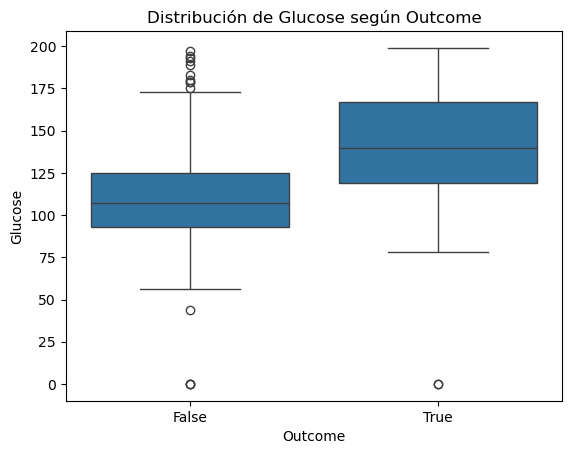

In [ ]:
# Distribución de Glucose según Outcome
sns.boxplot(x='Outcome', y='Glucose', data=data)
plt.title('Distribución de Glucose según Outcome')
plt.show()

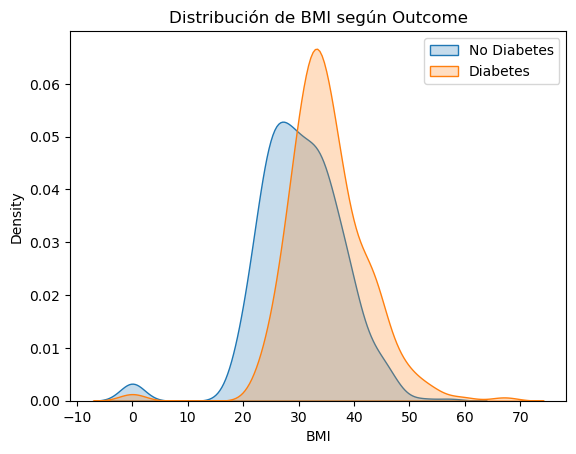

In [ ]:
# Distribución de BMI según Outcome
sns.kdeplot(data=data[data['Outcome'] == 0]['BMI'], label='No Diabetes', fill=True)
sns.kdeplot(data=data[data['Outcome'] == 1]['BMI'], label='Diabetes', fill=True)
plt.title('Distribución de BMI según Outcome')
plt.legend()
plt.show()

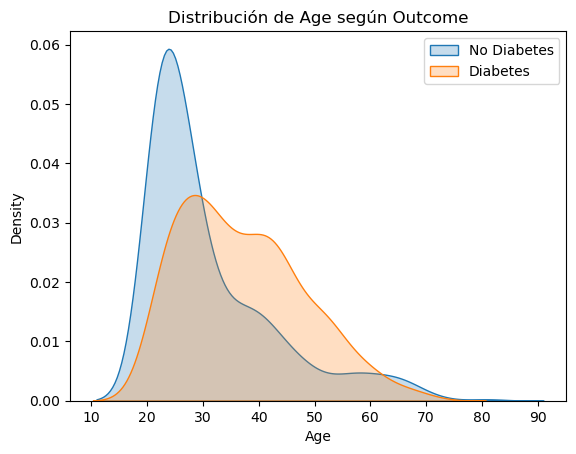

In [14]:
sns.kdeplot(data=data[data['Outcome'] == 0]['Age'], label='No Diabetes', fill=True)
sns.kdeplot(data=data[data['Outcome'] == 1]['Age'], label='Diabetes', fill=True)
plt.title('Distribución de Age según Outcome')
plt.legend()
plt.show()

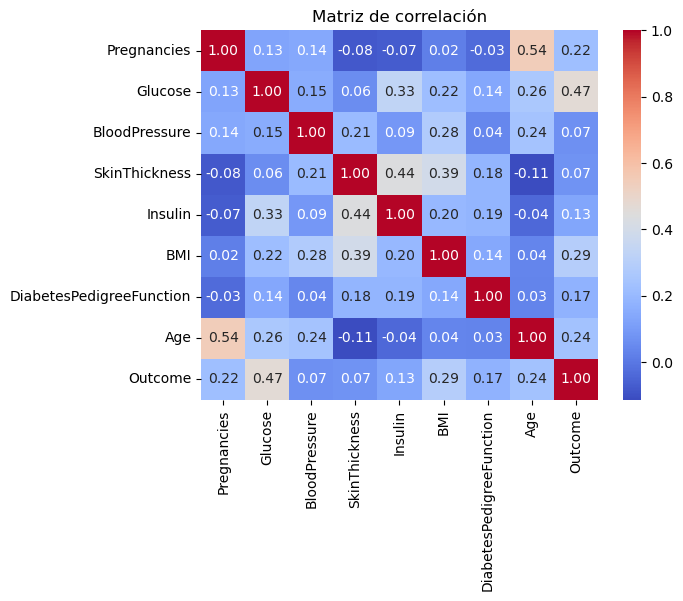

In [16]:
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de correlación')
plt.show()

# 3)Implementación de Modelos:

## Modelos de Clasificación: Implementa modelos de Random Forest y XGBoost.

In [22]:
numerical_columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'BMI', 'DiabetesPedigreeFunction', 'Age']

X = data[numerical_columns]
y = data['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


### Random Forest Classifier

In [ ]:
# Random Forest Classifier sin las columnas insulin y skinthickness
# Entrenar el modelo Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, random_state=42)
rf.fit(X_train, y_train)

# Realizar predicciones
y_pred = rf.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Exactitud: {accuracy}')
print('Informe de Clasificación:')
print(classification_report(y_test, y_pred, zero_division=1))

# Matriz de Confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print('Matriz de Confusión:')
print(conf_matrix)

Exactitud: 0.7359307359307359
Informe de Clasificación:
              precision    recall  f1-score   support

       False       0.81      0.77      0.79       151
        True       0.61      0.66      0.63        80

    accuracy                           0.74       231
   macro avg       0.71      0.72      0.71       231
weighted avg       0.74      0.74      0.74       231

Matriz de Confusión:
[[117  34]
 [ 27  53]]


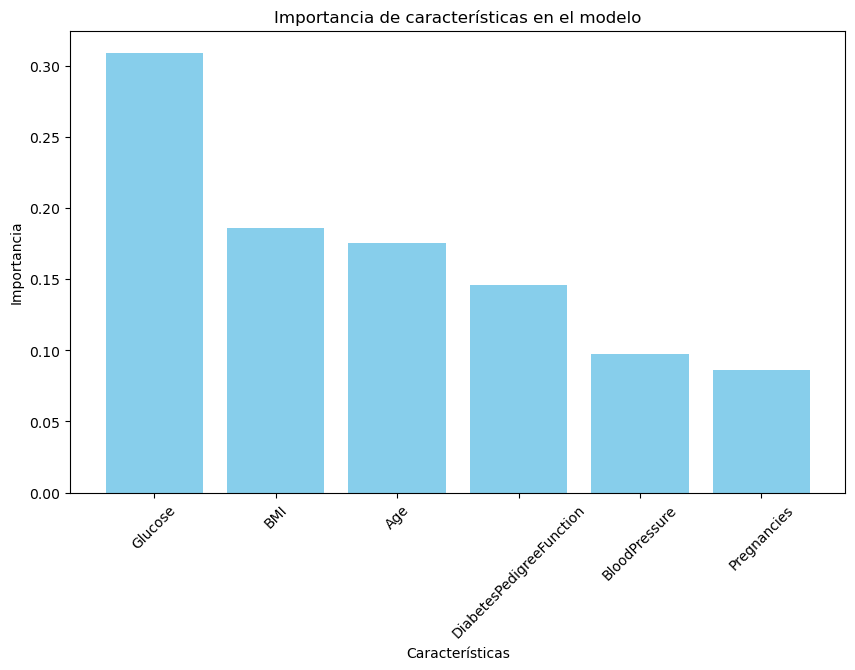

In [26]:
# Importancia de las características
importances = rf.feature_importances_
feature_importances = pd.DataFrame({'Feature': numerical_columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Visualizar la importancia
plt.figure(figsize=(10, 6))
plt.bar(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.title('Importancia de características en el modelo')
plt.xlabel('Características')
plt.ylabel('Importancia')
plt.xticks(rotation=45)
plt.show()

In [30]:
# Definir el modelo base
model = RandomForestClassifier(random_state=42)

# Especificar el rango de hiperparámetros a probar
param_grid = {
    'n_estimators': [50, 100],  # Número de árboles
    'max_depth': [None, 10, 20],  # Profundidad máxima de los árboles
    'min_samples_split': [2, 5],  # Número mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],  # Número mínimo de muestras en una hoja
    'bootstrap': [True, False]  # Si se usa bootstrap para crear las muestras
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# Ejecutar la búsqueda
grid_search.fit(X_train, y_train)

# Ver los mejores parámetros
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)

# Mejor puntuación
print(f"Mejor puntuación de validación cruzada: {grid_search.best_score_:.2f}")

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Mejores parámetros encontrados:
{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Mejor puntuación de validación cruzada: 0.79


In [32]:
# Prueba Random Forest Classifier con los mejores hiperparámetros y con todas las columnas de data pero con menos datos

# Eliminar filas donde Insulin o SkinThickness tienen valor 0
data_reduced = data[(data['Insulin'] != 0) & (data['SkinThickness'] != 0)]

X = data_reduced[numerical_columns]
y = data_reduced['Outcome']

# Dividir en entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo Random Forest
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluar el modelo
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy en el conjunto reducido: {accuracy:.2f}")
data_reduced.shape

Accuracy en el conjunto reducido: 0.78


(394, 9)

### XGBoost

[0]	train-logloss:0.60647	test-logloss:0.59490


[1]	train-logloss:0.57642	test-logloss:0.56854
[2]	train-logloss:0.55877	test-logloss:0.56141
[3]	train-logloss:0.53677	test-logloss:0.54206
[4]	train-logloss:0.51558	test-logloss:0.52379
[5]	train-logloss:0.50238	test-logloss:0.51939
[6]	train-logloss:0.49204	test-logloss:0.51863
[7]	train-logloss:0.48202	test-logloss:0.51344
[8]	train-logloss:0.47382	test-logloss:0.51035
[9]	train-logloss:0.45963	test-logloss:0.49566
[10]	train-logloss:0.44657	test-logloss:0.48383
[11]	train-logloss:0.43506	test-logloss:0.47506
[12]	train-logloss:0.42396	test-logloss:0.46465
[13]	train-logloss:0.41638	test-logloss:0.45683
[14]	train-logloss:0.40870	test-logloss:0.45275
[15]	train-logloss:0.40222	test-logloss:0.45272
[16]	train-logloss:0.39729	test-logloss:0.44867
[17]	train-logloss:0.38931	test-logloss:0.44250
[18]	train-logloss:0.38468	test-logloss:0.43823
[19]	train-logloss:0.38093	test-logloss:0.43915
[20]	train-logloss:0.37720	test-logloss:0.43779
[21]	train-logloss:0.37404	test-logloss:0.43832
[

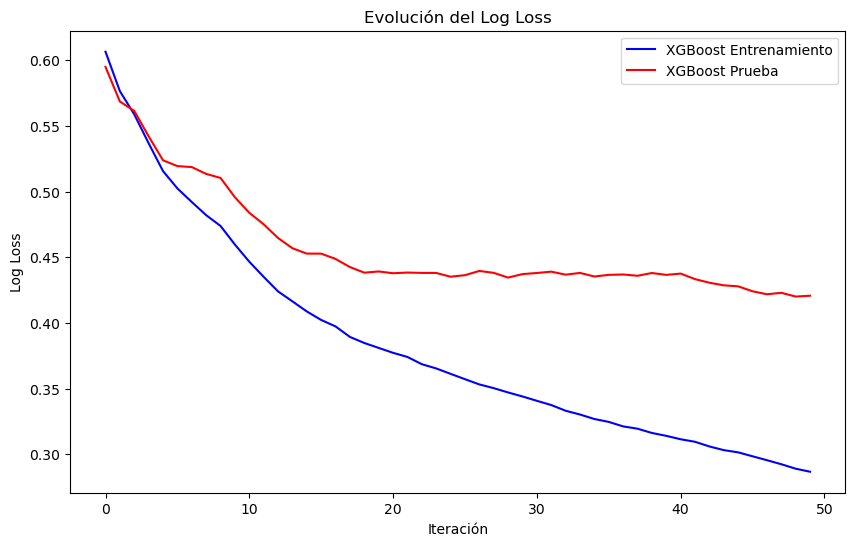

Matriz de Confusión - XGBoost:
[[46  8]
 [ 9 16]]

Métricas de Clasificación - XGBoost:
Precisión (Accuracy): 0.7848
Precisión (Precision): 0.6667
Recall (Sensibilidad): 0.6400
F1-Score: 0.6531
AUC-ROC: 0.8659

Reporte de Clasificación - XGBoost:
              precision    recall  f1-score   support

       False       0.84      0.85      0.84        54
        True       0.67      0.64      0.65        25

    accuracy                           0.78        79
   macro avg       0.75      0.75      0.75        79
weighted avg       0.78      0.78      0.78        79



In [ ]:
# Configuración de los datos para XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Configuración de parámetros para XGBoost
xgb_params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "eta": 0.1,  # Learning rate
    "max_depth": 3,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "random_state": 42,
}

# Diccionario para almacenar los resultados de evaluación de XGBoost
xgb_evals_result = {}

# Entrenar el modelo de XGBoost con registro de resultados
xgb_eval = [(dtrain, "train"), (dtest, "test")]
xgb_model = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=50,
    evals=xgb_eval,
    evals_result=xgb_evals_result,  # Almacenar resultados de evaluación
)
# Obtener predicciones y evaluar
xgb_preds = xgb_model.predict(dtest)
xgb_accuracy = accuracy_score(y_test, (xgb_preds > 0.5).astype(int))
xgb_logloss = log_loss(y_test, xgb_preds)

# Mostrar resultados
print("Resultados de XGBoost:")
print(f"Exactitud: {xgb_accuracy:.4f}")
print(f"Log Loss: {xgb_logloss:.4f}")

# Graficar la evolución del log loss en entrenamiento y prueba
plt.figure(figsize=(10, 6))
plt.plot(
    xgb_evals_result["train"]["logloss"], label="XGBoost Entrenamiento", color="blue"
)
plt.plot(
    xgb_evals_result["test"]["logloss"], label="XGBoost Prueba", color="red"
)
plt.xlabel("Iteración")
plt.ylabel("Log Loss")
plt.title("Evolución del Log Loss")
plt.legend()
plt.show()

# Calcular métricas para XGBoost
xgb_y_pred_binary = (xgb_preds > 0.5).astype(int)

xgb_cm = confusion_matrix(y_test, xgb_y_pred_binary)
print("Matriz de Confusión - XGBoost:")
print(xgb_cm)

xgb_accuracy = accuracy_score(y_test, xgb_y_pred_binary)
xgb_precision = precision_score(y_test, xgb_y_pred_binary)
xgb_recall = recall_score(y_test, xgb_y_pred_binary)
xgb_f1 = f1_score(y_test, xgb_y_pred_binary)
xgb_roc_auc = roc_auc_score(y_test, xgb_preds)

print("\nMétricas de Clasificación - XGBoost:")
print(f"Precisión (Accuracy): {xgb_accuracy:.4f}")
print(f"Precisión (Precision): {xgb_precision:.4f}")
print(f"Recall (Sensibilidad): {xgb_recall:.4f}")
print(f"F1-Score: {xgb_f1:.4f}")
print(f"AUC-ROC: {xgb_roc_auc:.4f}")

# Reporte de clasificación para XGBoost
print("\nReporte de Clasificación - XGBoost:")
print(classification_report(y_test, xgb_y_pred_binary))

# codigo extraido de la clase de machine learning, booting parte 2

## Comparación de Rendimiento:

Precisión (Accuracy): 0.7848
Reporte de Clasificación - XGBoost:
              precision    recall  f1-score   support

       False       0.84      0.85      0.84        54
        True       0.67      0.64      0.65        25

    accuracy                           0.78        79
   macro avg       0.75      0.75      0.75        79
weighted avg       0.78      0.78      0.78        79



Exactitud: 0.7359307359307359
Informe de Clasificación: Random Forest Clasiffier
              precision    recall  f1-score   support

       False       0.81      0.77      0.79       151
        True       0.61      0.66      0.63        80

    accuracy                           0.74       231
   macro avg       0.71      0.72      0.71       231
weighted avg       0.74      0.74      0.74       231

* Antes de analizar los resultados es necesario mencionar ciertos problemas del dataset como la enorme cantidad de datos
con "0" que posiblemente fueron utilizados a modo de reemplazo a los datos nulos ademas de un dudoso rango en las metricas de algunas columnas que no coincidian del todo con el rango medico normal pero que seria imprudente tratar de corregirlos sin tener mas conocimiento del tema
* Para este Dataset se obtiene una mejor precision con el modelo XGBoost sin ajustar los parametros
* En una prueba con random forest con los datos reducidos practicamente a la mitad eliminando datos de 2 columnas se obtuvo una precision de 0,,78 (Pero existe la duda si son datos sufuciente para entrenar el modelo)
* Aplicando gridsearchSV en el modelo de Random Forest Classifier se obtuvo una precision de 0,79
* ***En conclusion en un dataset pequeño cuya complejidad es baja y el target solo tiene 2 resultados posibles, ambos obtuvieron resultados similares***